In [30]:
import torch
from torchvision.transforms import Compose, functional
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import dill
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from pyro.infer import Predictive, Trace_ELBO
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

### Adding sentiment information

In [46]:
N_COLS = 4
INPUT_SHAPE = [8,4]
INPUT_SIZE = 5
Z_DIM = 50
DATA_PATH ='d_dfs_sent.pkd'
NN_PREDICTIONS_PATH = 'predictions_baseline_sent1_z50.pkd'
CVAE_PREDICTIONS_PATH = 'predictions_cvae__sent1_z50.pkd'

In [61]:
class STOCK(Dataset):
    def __init__(self, pd_df, input_size = INPUT_SIZE, mask_size=3, n_cols=N_COLS, train = True):
        self.ncols = n_cols
        self.original, self.test_low, self.test_high, self.minmax = self.loadData(pd_df, input_size, mask_size)
        self.transform =  Compose([ToTensor(), MaskData(pos=mask_size)])
        self.train = train
    def __len__(self):
        return len(self.original)

    def __getitem__(self, item):
        sample = {"original":self.original[item]}
        test_low = {"original":self.test_low[0]}
        test_high = {"original":self.test_high[0]}
        if self.transform:
            sample = self.transform(sample)
            test_low = self.transform(test_low)
            test_high = self.transform(test_high)
        if self.train:
            return sample
        else:
            return {'input_low': test_low['input'], 'input_high': test_high['input']}
    
    def loadData(self, df, input_size, mask_size):
    
        minmax = MinMaxScaler().fit(df[['close','high','low']].values.reshape(-1,3))
        df_norm = pd.DataFrame(minmax.transform(df[['close','high','low']].values.reshape(-1,3)))
        
        df_norm.index = df.index
        df_norm.columns = ['close','high','low']
   
        add_cols = []
        if self.ncols > 3:
        #    add_cols = ['relevance_score','ticker_sentiment_score' ]
        #    for col in add_cols:
        #        df_norm[col] = (df[col] + 1)/2
            df_norm['sentiment'] =(df['relevance_score']*df['ticker_sentiment_score']+1)/2

        dataset = []
        for i in range(len(df_norm) - (input_size+mask_size) - 1):
            dataset.append(df_norm.iloc[i:i + (input_size+mask_size),:])
        
        testset_low = [pd.concat([df_norm.iloc[-(input_size+mask_size-1) : -1],pd.DataFrame(
            [dict(zip(df_norm.columns,[0]*len(df_norm.columns)))]*2)])]
        
        testset_high = [pd.concat([df_norm.iloc[-input_size : ]
                        ,pd.DataFrame([dict(zip(df_norm.columns
                                                ,[0]*len(df_norm.columns)))]*mask_size)])]

        return dataset, testset_low, testset_high, minmax
    
    def reverseMinMax(self, pred):
        return self.minmax.inverse_transform(pred)

class ToTensor:
    def __call__(self, sample):
        sample['original'] = torch.from_numpy(sample['original'].values).float()
        return sample

class MaskData:
    """This transformation masks the values to be predicted with -1 and
    adds the target output in the sample dict as the complementary of the input
    """

    def __init__(self, pos=1, mask_with=-1):
        self.mask_with = mask_with
        self.pos = -pos

    def __call__(self, sample):
        tensor = sample['original']
        inp = tensor.detach().clone()

        # remove the last one
        inp[self.pos:] = self.mask_with

        # now, sets the input as complementary
        out = tensor.clone()
        out[inp != -1] = self.mask_with

        sample["input"] = inp
        sample["output"] = out
        
        # Remove the sentiment from output so that we dont calculate loss for it.
        out[self.pos:, 3:] = -1
        return sample


In [62]:
pd.read_pickle(DATA_PATH)['COST'][datetime(2022,10,27)].tail(15)

,close,high,low,relevance_score,ticker_sentiment_score
date,,,,,
2022-10-07,468.15,479.1050,466.1200,0.485711,0.140444
2022-10-10,466.31,470.2500,461.6100,0.431765,0.129190
2022-10-11,472.02,477.2500,463.7000,0.901780,0.335862
2022-10-12,466.38,479.7400,466.3000,0.645516,0.345227
2022-10-13,467.99,471.7400,449.0300,0.159569,0.207263
2022-10-14,454.65,473.3900,453.7900,0.381949,0.124561
2022-10-17,464.17,466.8799,460.4800,0.895116,0.317930
2022-10-18,473.27,476.5205,468.8300,0.706550,0.352159
2022-10-19,471.43,474.8667,466.9500,0.980595,0.386944


In [63]:
def get_data(df, batch_size=16):
    data, dl, ds = {}, {}, {}
    data['train'] = STOCK(df)
    data['test'] = STOCK(df, train = False)
    dl['train'] = DataLoader(data['train'], batch_size=batch_size, shuffle=True, num_workers=0)
    dl['val'] = DataLoader(data['train'], batch_size=batch_size, shuffle=False, num_workers=0)
    ds['train'] = ds['val'] = len(dl['train'])
    return data, dl, ds

def get_all_data(filepath = DATA_PATH):
    datasets, dataloaders, dataset_sizes = defaultdict(dict), defaultdict(dict), defaultdict(dict)
    d_all = pd.read_pickle(filepath)
    for ticker, dates in d_all.items():    
        for date,df in dates.items():
            datasets[ticker][date], dataloaders[ticker][date], dataset_sizes[ticker][date] = get_data(df)
    return datasets, dataloaders, dataset_sizes
datasets, dataloaders, dataset_sizes = get_all_data()

In [64]:
datasets['COST'][datetime(2022,10,27)]['train'].original

[               close      high       low  sentiment
 date                                               
 2021-10-29  0.391974  0.356123  0.419161        0.5
 2021-11-01  0.393696  0.360056  0.421985        0.5
 2021-11-02  0.420415  0.385127  0.450853        0.5
 2021-11-03  0.448283  0.404045  0.466700        0.5
 2021-11-04  0.517639  0.498092  0.520357        0.5
 2021-11-05  0.504592  0.485498  0.534058        0.5
 2021-11-08  0.456007  0.461018  0.489972        0.5
 2021-11-09  0.481578  0.437520  0.510158        0.5,
                close      high       low  sentiment
 date                                               
 2021-11-01  0.393696  0.360056  0.421985        0.5
 2021-11-02  0.420415  0.385127  0.450853        0.5
 2021-11-03  0.448283  0.404045  0.466700        0.5
 2021-11-04  0.517639  0.498092  0.520357        0.5
 2021-11-05  0.504592  0.485498  0.534058        0.5
 2021-11-08  0.456007  0.461018  0.489972        0.5
 2021-11-09  0.481578  0.437520  0.510158    

In [65]:
datasets['COST'][datetime(2022, 10, 27)]['train'][-1]

{'original': tensor([[0.1995, 0.2428, 0.2473, 0.5238],
         [0.2491, 0.2073, 0.2822, 0.6423],
         [0.2966, 0.2599, 0.3259, 0.6244],
         [0.2870, 0.2509, 0.3161, 0.6897],
         [0.2515, 0.2357, 0.2950, 0.5335],
         [0.3223, 0.2765, 0.2917, 0.7197],
         [0.4203, 0.3770, 0.3896, 0.6732],
         [0.4312, 0.3889, 0.4392, 0.5997]]),
 'input': tensor([[ 0.1995,  0.2428,  0.2473,  0.5238],
         [ 0.2491,  0.2073,  0.2822,  0.6423],
         [ 0.2966,  0.2599,  0.3259,  0.6244],
         [ 0.2870,  0.2509,  0.3161,  0.6897],
         [ 0.2515,  0.2357,  0.2950,  0.5335],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000]]),
 'output': tensor([[-1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [

In [66]:
datasets['COST'][datetime(2022, 10, 27)]['test'][0]

{'input_low': tensor([[ 0.2870,  0.2509,  0.3161,  0.6897],
         [ 0.2515,  0.2357,  0.2950,  0.5335],
         [ 0.3223,  0.2765,  0.2917,  0.7197],
         [ 0.4203,  0.3770,  0.3896,  0.6732],
         [ 0.4312,  0.3889,  0.4392,  0.5997],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000]]),
 'input_high': tensor([[ 0.3223,  0.2765,  0.2917,  0.7197],
         [ 0.4203,  0.3770,  0.3896,  0.6732],
         [ 0.4312,  0.3889,  0.4392,  0.5997],
         [ 0.4333,  0.4284,  0.4664,  0.5109],
         [ 0.4181,  0.4043,  0.4583,  0.5551],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000]])}

In [67]:
import copy
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


class BaselineNet(nn.Module):
    def __init__(self, hidden_1, hidden_2, input_shape=INPUT_SHAPE):
        super().__init__()
        self.fc1 = nn.Linear(np.prod(input_shape), hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, np.prod(input_shape))
        self.relu = nn.ReLU()
        self.input_shape = input_shape

    def forward(self, x):
        x = x.view(-1, np.prod(self.input_shape))
        hidden = self.relu(self.fc1(x))
        hidden = self.relu(self.fc2(hidden))
        y = torch.sigmoid(self.fc3(hidden))
        return y


class MaskedMSELoss(nn.Module):
    def __init__(self, masked_with=-1):
        super().__init__()
        self.masked_with = masked_with

    def forward(self, input, target):
        target = target.view(input.shape)
        loss = F.mse_loss(input, target, reduction="none")
        loss[target == self.masked_with] = 0
        return loss.sum()


def train_baseline(
    device,
    dataloaders,
    dataset_sizes,
    learning_rate,
    num_epochs,
    early_stop_patience,
    model_path=None,
    input_shape = INPUT_SHAPE
):
    # Train baseline
    baseline_net = BaselineNet(500, 500,input_shape=input_shape)
    baseline_net.to(device)
    optimizer = torch.optim.Adam(baseline_net.parameters(), lr=learning_rate)
    criterion = MaskedMSELoss()
    best_loss = np.inf
    early_stop_count = 0

    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                baseline_net.train()
            else:
                baseline_net.eval()

            running_loss = 0.0
            num_preds = 0

            #bar = tqdm(dataloaders[phase], desc="NN Epoch {} {}".format(epoch, phase).ljust(20))

            #for i, batch in enumerate(bar):
            for batch in dataloaders[phase]:#don't want 100 epoch bars for each of hundreds of models
                inputs = batch["input"].to(device)
                outputs = batch["output"].to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    preds = baseline_net(inputs)
                    loss = criterion(preds, outputs) / inputs.size(0)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                num_preds += 1
                #if i % 10 == 0:
                #    bar.set_postfix(
                #        loss="{:.2f}".format(running_loss / num_preds),
                #        early_stop_count=early_stop_count,
                #    )

            epoch_loss = running_loss / dataset_sizes[phase]
            # deep copy the model
            if phase == "val":
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(baseline_net.state_dict())
                    early_stop_count = 0
                else:
                    early_stop_count += 1

        if early_stop_count >= early_stop_patience:
            break

    baseline_net.load_state_dict(best_model_wts)
    baseline_net.eval()

    # Save model weights
    #Path(model_path).parent.mkdir(parents=True, exist_ok=True)
    #torch.save(baseline_net.state_dict(), model_path)

    return baseline_net


In [68]:
baseline_net = train_baseline(device=torch.device(
        "cuda:0" if torch.cuda.is_available() else "cpu"),
            dataloaders=dataloaders['COST'][datetime(2022, 10, 27)],
            dataset_sizes=dataset_sizes['COST'][datetime(2022, 10, 27)],
            learning_rate=1.0e-3,
            num_epochs=101,
            early_stop_patience=20,
            model_path="baseline_net.pth")

In [69]:
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO


class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_1, hidden_2, input_shape=INPUT_SHAPE):
        super().__init__()
        self.fc1 = nn.Linear(np.prod(input_shape), hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc31 = nn.Linear(hidden_2, z_dim)
        self.fc32 = nn.Linear(hidden_2, z_dim)
        self.relu = nn.ReLU()
        self.input_shape = input_shape

    def forward(self, x, y):
        # put x and y together in the same tensor for simplification
        xc = x.clone()
        xc[x == -1] = y[x == -1]
        xc = xc.view(-1, np.prod(self.input_shape))
        # then compute the hidden units
        hidden = self.relu(self.fc1(xc))
        hidden = self.relu(self.fc2(hidden))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc31(hidden)
        z_scale = torch.exp(self.fc32(hidden))
        return z_loc, z_scale


class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_1, hidden_2,  input_shape=INPUT_SHAPE):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, np.prod(input_shape))
        self.relu = nn.ReLU()

    def forward(self, z):
        y = self.relu(self.fc1(z))
        y = self.relu(self.fc2(y))
        y = torch.sigmoid(self.fc3(y))
        #y = self.fc3(y)
        return y


class CVAE(nn.Module):
    def __init__(self, z_dim, hidden_1, hidden_2, pre_trained_baseline_net,  input_shape=INPUT_SHAPE):
        super().__init__()
        # The CVAE is composed of multiple MLPs, such as recognition network
        # qφ(z|x, y), (conditional) prior network pθ(z|x), and generation
        # network pθ(y|x, z). Also, CVAE is built on top of the NN: not only
        # the direct input x, but also the initial guess y_hat made by the NN
        # are fed into the prior network.
        self.baseline_net = pre_trained_baseline_net
        self.prior_net = Encoder(z_dim, hidden_1, hidden_2)
        self.generation_net = Decoder(z_dim, hidden_1, hidden_2)
        self.recognition_net = Encoder(z_dim, hidden_1, hidden_2)
        self.input_shape = input_shape

    def model(self, xs, ys=None):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("generation_net", self)
        batch_size = xs.shape[0]

        with pyro.plate("data"):
            # Prior network uses the baseline predictions as initial guess.
            # This is the generative process with recurrent connection
            with torch.no_grad():
                # this ensures the training process does not change the
                # baseline network
                y_hat = self.baseline_net(xs).view(xs.shape)

            # sample the handwriting style from the prior distribution, which is
            # modulated by the input xs.
            prior_loc, prior_scale = self.prior_net(xs, y_hat)
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))

            # the output y is generated from the distribution pθ(y|x, z)
            loc = self.generation_net(zs)

            if ys is not None:
                # In training, we will only sample in the masked image
                mask_loc = loc[(xs == -1).view(-1, np.prod(self.input_shape))].view(batch_size, -1)
                mask_ys = ys[xs == -1].view(batch_size, -1)
                
                pyro.deterministic("y", loc)

            else:
                # In testing, no need to sample: the output is already a
                # probability in [0, 1] range, which better represent pixel
                # values considering grayscale. If we sample, we will force
                # each pixel to be  either 0 or 1, killing the grayscale
                pyro.deterministic("y", loc.detach())

            # return the loc so we can visualize it later
            return loc

    def guide(self, xs, ys=None):
        with pyro.plate("data"):
            if ys is None:
                # at inference time, ys is not provided. In that case,
                # the model uses the prior network
                y_hat = self.baseline_net(xs).view(xs.shape)
                loc, scale = self.prior_net(xs, y_hat)
            else:
                # at training time, uses the variational distribution
                # q(z|x,y) = normal(loc(x,y),scale(x,y))
                loc, scale = self.recognition_net(xs, ys)
            
            pyro.sample("z", dist.Normal(loc, scale).to_event(1))


def train_cvae(
    device,
    dataloaders,
    dataset_sizes,
    learning_rate,
    num_epochs,
    early_stop_patience,
    model_path="cvae_net1.pth",
    pre_trained_baseline_net=baseline_net,
):
    # clear param store
    pyro.clear_param_store()

    cvae_net = CVAE(Z_DIM, 500, 500, pre_trained_baseline_net)
    cvae_net.to(device)
    optimizer = pyro.optim.Adam({"lr": learning_rate})
    svi = SVI(cvae_net.model, cvae_net.guide, optimizer, loss=Trace_ELBO())

    best_loss = np.inf
    early_stop_count = 0
    Path(model_path).parent.mkdir(parents=True, exist_ok=True)
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            running_loss = 0.0
            num_preds = 0

            # Iterate over data.
            #bar = tqdm(
            #    dataloaders[phase],
            #    desc="CVAE Epoch {} {}".format(epoch, phase).ljust(20))
            #for i,batch in enumerate(bar):
            for batch in dataloaders[phase]:#don't want epoch bars for hundreds of models
                inputs = batch["input"].to(device)
                outputs = batch["output"].to(device)

                if phase == "train":
                    loss = svi.step(inputs, outputs)
                else:
                    loss = svi.evaluate_loss(inputs, outputs)

                # statistics
                running_loss += loss / inputs.size(0)
                num_preds += 1
                #if i % 10 == 0:
                #    bar.set_postfix(
                #        loss="{:.2f}".format(running_loss / num_preds),
                #        early_stop_count=early_stop_count)

            epoch_loss = running_loss / dataset_sizes[phase]
            # deep copy the model
            if phase == "val":
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(cvae_net.state_dict(), model_path)
                    early_stop_count = 0
                else:
                    early_stop_count += 1

        if early_stop_count >= early_stop_patience:
            break

    # Save model weights
    cvae_net.load_state_dict(torch.load(model_path))
    cvae_net.eval()
    return cvae_net

cvae_net = train_cvae(
            device=torch.device(
        "cuda:0" if torch.cuda.is_available() and args.cuda else "cpu"),
            dataloaders=dataloaders['COST'][datetime(2022, 10, 27)],
            dataset_sizes=dataset_sizes['COST'][datetime(2022, 10, 27)],
            learning_rate=1.0e-3,
            num_epochs=101,
            early_stop_patience=20,
            model_path="cvae_net1.pth",
            pre_trained_baseline_net=baseline_net,
        )


In [70]:
def train_predict(ticker, date
        , device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), mask_shape=[INPUT_SIZE,3]):
    d_baseline, d_cvae = {}, {}
    dataset = datasets[ticker][date]
    dataloader_test = DataLoader(dataset["test"], batch_size=1, shuffle=False)
    batch = next(iter(dataloader_test))
    
    def get_pred(model, input_type, prelim_high_prediction=False):
        ### input_type: input_low or input_high
        prediction = model(batch[input_type].to(device))
        if type(prediction) == dict:
            prediction = prediction['y']
        prediction = prediction.reshape(-1,N_COLS).detach()
        
        prediction = torch.from_numpy(dataset['test'].reverseMinMax(prediction[:,:3]))
        index = {'input_low':2, 'input_high':1}
        if input_type == 'input_low' and prelim_high_prediction:
            return prediction[mask_shape[0], index['input_low']].item()\
                    , prediction[mask_shape[0]+mask_shape[1]-1, index['input_high']].item()
        return prediction[mask_shape[0], index[input_type]].item(),0
    
    baseline_net = train_baseline(device=device,
            dataloaders=dataloaders[ticker][date],
            dataset_sizes=dataset_sizes[ticker][date],
            learning_rate=1.0e-3,
            num_epochs=101,
            early_stop_patience=20, input_shape=(sum(mask_shape), N_COLS))

    d_baseline['low'], d_baseline['estimated_high'] = get_pred(baseline_net, 'input_low', prelim_high_prediction = True)
    d_baseline['high'] = get_pred(baseline_net, 'input_high')[0]
    
    cvae_net = train_cvae(device,
            dataloaders=dataloaders[ticker][date],
            dataset_sizes=dataset_sizes[ticker][date],
            learning_rate=1.0e-3,
            num_epochs=101,
            early_stop_patience=20,
            pre_trained_baseline_net=baseline_net,)
    predictive = Predictive(cvae_net.model, guide=cvae_net.guide, num_samples=1)

    d_cvae['low'], d_cvae['estimated_high'] = get_pred(predictive, 'input_low' , prelim_high_prediction = True)
    d_cvae['high'] = get_pred(predictive, 'input_high')[0]

    return d_baseline,d_cvae

def get_predictions():
    d_all = pd.read_pickle(DATA_PATH)
    d_baseline, d_cvae = defaultdict(dict), defaultdict(dict)
    for ticker, dates in d_all.items():
        for date,df in dates.items():
            print(ticker,date)
            d_baseline[ticker][date], d_cvae[ticker][date] = train_predict(ticker, date)
        dill.dump(d_baseline,open(NN_PREDICTIONS_PATH,'wb'))
        dill.dump(d_cvae,open(CVAE_PREDICTIONS_PATH,'wb'))
    return d_baseline, d_cvae

get_predictions()


COST 2022-10-27 00:00:00
COST 2023-02-02 00:00:00
COST 2023-05-04 00:00:00
COST 2023-08-24 00:00:00
COST 2023-11-02 00:00:00
CE 2022-10-28 00:00:00
CE 2023-07-28 00:00:00
CE 2023-10-27 00:00:00
AON 2022-10-31 00:00:00
AON 2023-01-31 00:00:00
AON 2023-04-28 00:00:00
AON 2023-07-31 00:00:00
AON 2023-10-31 00:00:00
MKTX 2022-11-01 00:00:00
MKTX 2023-02-07 00:00:00
MKTX 2023-05-09 00:00:00
MKTX 2023-08-01 00:00:00
CAG 2022-11-02 00:00:00
CAG 2023-11-01 00:00:00
NSC 2022-11-03 00:00:00
NSC 2023-08-03 00:00:00
AMP 2022-11-04 00:00:00
AMP 2023-02-09 00:00:00
AMP 2023-08-04 00:00:00
AWK 2022-11-07 00:00:00
AWK 2023-02-06 00:00:00
AWK 2023-05-08 00:00:00
AWK 2023-08-07 00:00:00
WST 2022-11-08 00:00:00
WST 2023-01-24 00:00:00
WST 2023-04-25 00:00:00
WST 2023-07-25 00:00:00
POOL 2022-11-09 00:00:00
POOL 2023-05-16 00:00:00
POOL 2023-08-09 00:00:00
GWW 2022-11-10 00:00:00
GWW 2023-02-10 00:00:00
GWW 2023-05-05 00:00:00
GWW 2023-08-11 00:00:00
TFX 2022-11-14 00:00:00
TFX 2023-03-02 00:00:00
TFX 202

(defaultdict(dict,
             {'COST': {datetime.datetime(2022, 10, 27, 0, 0): {'low': 484.2051831966102,
                'estimated_high': 497.0780216020346,
                'high': 500.5843793284893},
               datetime.datetime(2023, 2, 2, 0, 0): {'low': 505.0979087618649,
                'estimated_high': 511.8748189562559,
                'high': 530.172617021799},
               datetime.datetime(2023, 5, 4, 0, 0): {'low': 486.49712199236154,
                'estimated_high': 496.2411946892738,
                'high': 492.67428075671194},
               datetime.datetime(2023, 8, 24, 0, 0): {'low': 531.5815863847732,
                'estimated_high': 539.0598113632202,
                'high': 536.8268689346313},
               datetime.datetime(2023, 11, 2, 0, 0): {'low': 549.1082422614097,
                'estimated_high': 557.7827325481176,
                'high': 562.2974862802027}},
              'CE': {datetime.datetime(2022, 10, 28, 0, 0): {'low': 92.0006351673603,
 

In [24]:
d_all_EOD = dill.load(open('d_all_EOD.pkd','rb'))
for ticker in d_all_EOD.keys():
    d_all_EOD[ticker] = d_all_EOD[ticker].reset_index(drop=True)

In [25]:
def find_low(ticker, date):
    df_truth = d_all_EOD[ticker]
    df1 = df_truth[df_truth.date==date]
    index = df1.index[0]
    return df_truth.iloc[index-1]['low']

def find_high(ticker,date):
    df_truth = d_all_EOD[ticker]
    df1 = df_truth[df_truth.date==date]
    index = df1.index[0]
    return df_truth.iloc[index+1]['high']

def calc_pe(prediction,true_value):
    return 100*(prediction - true_value)/true_value

def calc_ape(prediction,true_value):
    return 100*np.abs(prediction - true_value)/true_value
    
def calc_mpe(d):
    l_temp =[]
    for ticker, dates in d.items():
        for date, df in dates.items():
            true_low = find_low(ticker,date)
            true_high = find_high(ticker,date)
            l_temp.append({'date': date, 'ticker': ticker,
                        'pe_low': calc_pe(d[ticker][date]['low'], true_low), 
                        'pe_high': calc_pe(d[ticker][date]['high'], true_high),
                        'ape_low': calc_ape(d[ticker][date]['low'], true_low),
                        'ape_high': calc_ape(d[ticker][date]['high'], true_high)})
    df_results = pd.DataFrame(l_temp)
    
    print('MPE Low:',df_results.pe_low.mean())
    print('MPE High:',df_results.pe_high.mean())
    print('MPE Overall:',df_results[['pe_low','pe_high']].mean()[0])
    print('MAPE Low:',df_results.ape_low.mean())
    print('MAPE High:',df_results.ape_high.mean())
    print('MAPE Overall:',df_results[['ape_low','ape_high']].mean()[0])
    
    return df_results.sort_values('date').reset_index(drop=True)

def show_results(predictions_path):
    df = calc_mpe(dill.load(open(predictions_path,'rb')))
    return alt.Chart(df,title='PE for Low and High').mark_line().encode(x='date',y='pe_low')&\
alt.Chart(df).mark_line().encode(x='date',y='pe_high')

In [72]:
def show_results(predictions_path):
    df = calc_mpe(dill.load(open(predictions_path,'rb')))
    return df
    return alt.Chart(df,title='PE for Low and High').mark_line().encode(x='date',y='pe_low')&\
alt.Chart(df).mark_line().encode(x='date',y='pe_high')
show_results(CVAE_PREDICTIONS_PATH)

MPE Low: 0.26649749587839533
MPE High: 1.308410868631888
MPE Overall: 0.26649749587839533
MAPE Low: 11.110435064831796
MAPE High: 10.819459501604603
MAPE Overall: 11.110435064831796


,date,ticker,pe_low,pe_high,ape_low,ape_high
0,2022-10-27,COST,0.428479,0.795573,0.428479,0.795573
1,2022-10-28,CE,35.988745,37.428411,35.988745,37.428411
2,2022-10-31,AON,6.999822,3.847648,6.999822,3.847648
3,2022-11-01,MKTX,31.534554,37.653688,31.534554,37.653688
4,2022-11-02,CAG,-8.182047,-5.466881,8.182047,5.466881
...,...,...,...,...,...,...
228,2023-10-27,CE,-3.980177,-2.741801,3.980177,2.741801
229,2023-10-30,TXN,12.980791,15.161332,12.980791,15.161332
230,2023-10-31,AON,2.069366,0.629494,2.069366,0.629494
231,2023-11-01,CAG,19.834266,20.421203,19.834266,20.421203


In [71]:
def show_results(predictions_path):
    df = calc_mpe(dill.load(open(predictions_path,'rb')))
    return df
    return alt.Chart(df,title='PE for Low and High').mark_line().encode(x='date',y='pe_low')&\
alt.Chart(df).mark_line().encode(x='date',y='pe_high')
show_results(NN_PREDICTIONS_PATH)

MPE Low: -0.02747839168538977
MPE High: 0.17822576912126167
MPE Overall: -0.02747839168538977
MAPE Low: 1.3738052390573643
MAPE High: 1.4044952845786483
MAPE Overall: 1.3738052390573643


,date,ticker,pe_low,pe_high,ape_low,ape_high
0,2022-10-27,COST,-2.316935,-2.385948,2.316935,2.385948
1,2022-10-28,CE,-3.765026,-1.586693,3.765026,1.586693
2,2022-10-31,AON,2.364395,0.108482,2.364395,0.108482
3,2022-11-01,MKTX,-1.687145,2.896229,1.687145,2.896229
4,2022-11-02,CAG,-1.800977,0.142651,1.800977,0.142651
...,...,...,...,...,...,...
228,2023-10-27,CE,-0.573907,0.018331,0.573907,0.018331
229,2023-10-30,TXN,1.056100,1.641190,1.056100,1.641190
230,2023-10-31,AON,1.071851,-0.952381,1.071851,0.952381
231,2023-11-01,CAG,-0.800431,-0.515535,0.800431,0.515535


In [101]:
df = d_all_EOD['SPY']
df

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2010-01-04,113.33,113.390,111.5100,112.37,118857369,91.426173,91.474576,89.957933,90.651716,118857369,0.0,1.0
1,2010-01-05,113.63,113.680,112.8500,113.26,111519230,91.668190,91.708526,91.038944,91.369702,111519230,0.0,1.0
2,2010-01-06,113.71,113.990,113.4300,113.52,116017127,91.732728,91.958611,91.506845,91.579450,116017127,0.0,1.0
3,2010-01-07,114.19,114.330,113.1800,113.50,130502017,92.119956,92.232898,91.305164,91.563316,130502017,0.0,1.0
4,2010-01-08,114.57,114.620,113.6600,113.89,126357911,92.426512,92.466848,91.692392,91.877939,126357911,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3479,2023-10-30,415.59,416.680,412.2200,413.56,86562675,415.590000,416.680000,412.220000,413.560000,86562675,0.0,1.0
3480,2023-10-31,418.20,418.530,414.2100,416.18,79665150,418.200000,418.530000,414.210000,416.180000,79665150,0.0,1.0
3481,2023-11-01,422.66,423.500,418.6499,419.20,98068115,422.660000,423.500000,418.649900,419.200000,98068115,0.0,1.0
3482,2023-11-02,430.76,430.915,426.5600,426.58,94938909,430.760000,430.915000,426.560000,426.580000,94938909,0.0,1.0


<Axes: >

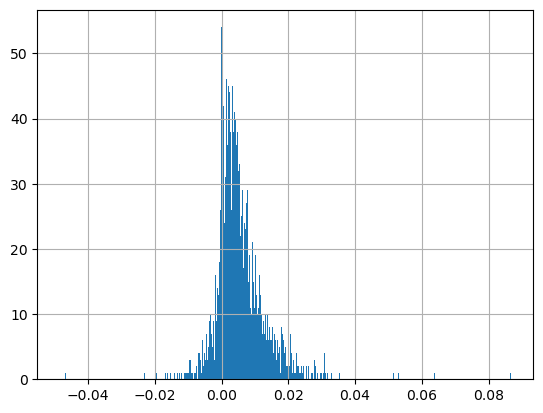

In [103]:
((df['high'] - df['close'].shift(fill_value=0))/df['high']).iloc[1:].hist(bins=1000)

array([[<Axes: title={'center': '0'}>]], dtype=object)

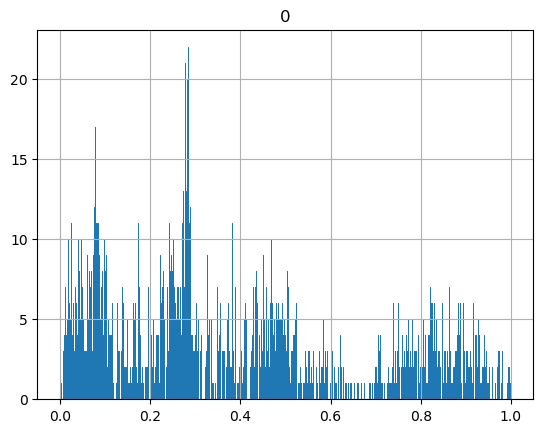

In [104]:
pd.DataFrame(MinMaxScaler().fit(df['high'].values.reshape(-1,1)).transform(df['high'].values.reshape(-1,1))).hist(bins=1000)